![image-2.png](attachment:image-2.png)
![image-3.png](attachment:image-3.png)

In [ ]:
#pip install pyDOE

In [ ]:
from sympy import*
import numpy as np
from pyDOE import lhs         #Latin Hypercube Sampling
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D   
import tensorflow as tf
from tensorflow import keras

# Setting

In [ ]:
x = symbols('x')
y = symbols('y')
t = symbols('t')

a = v1 = v2 = k =1 #a=4 ,v1=5,v2=10,k=1/4
c1 = 1 + v1/k ;c2 = -v1/v2;c3 = c2 - c1
g1 = g2 =0

u1 = a*x*(1-x)*(1-y)*exp(-t)
u2 = a*x*(1-x)*(c1 + c2*y + c3*y**2)*exp(-t)

u1_0 = a*x*(1-x)*(1-y)
u2_0 = a*x*(1-x)*(c1 + c2*y + c3*y**2)

f1 = diff(u1,t) - v1*( diff(u1,x,2) + diff(u1,y,2))
f2 = diff(u2,t) - v2*( diff(u2,x,2) + diff(u2,y,2))

u1 = lambdify((x,y,t),u1)
u2 = lambdify((x,y,t),u2)

u1_0 = lambdify((x,y),u1_0)
u2_0 = lambdify((x,y),u2_0)

f1 = lambdify((x,y,t),f1,'tensorflow')
f2 = lambdify((x,y,t),f2,'tensorflow')

# Define

In [ ]:
def trainingdata(N_u,N_f,N_i,omga,u,interface):    
    
    # x1 = x,  x2 = y
    # interface = 0, 则x2_range[0] 作为 interface ； interfacer = 1 则 x2_range[1]作为interface
    
    x1_range = omga[0]
    x2_range = omga[1]
    t_range = [0.,1.]
    
    x1 = np.linspace(x1_range[0],x1_range[1],N_u)
    x2 = np.linspace(x2_range[0],x2_range[1],N_u)
    t = np.linspace(t_range[0],t_range[1],N_u)
    
    # Initial Condition t=0 , x1_range[0]<= x1 <= x_range[1] , x2_range[0] <= x2 <= x2_range[1]
    X1,X2 = np.meshgrid(x1,x2)
    initial_X = np.zeros(shape=(N_u**2,3))
    initial_u = np.zeros(shape=(N_u**2,1))
    for i in range(N_u):
        for j in range(N_u):
            initial_X[i*N_u+j,:] = [X1[i][j], X2[i][j], t_range[0]]
            initial_u[i*N_u+j] = u(X1[i][j],X2[i][j], t_range[0]) 
            
    # BC_left: x1=x1_range[0], 0<=t<=1, x2_range[0] <= x2 <= x2_range[1]
    X2,T = np.meshgrid(x2,t)
    leftedge_X = np.zeros(shape=(N_u**2,3))
    leftedge_u = np.zeros(shape=(N_u**2,1))
    for i in range(N_u):
        for j in range(N_u):
            leftedge_X[i*N_u+j,:] = [x1_range[0], X2[i][j], T[i,j]]
            leftedge_u[i*N_u+j] = u(x1_range[0],X2[i][j], T[i,j]) 
    
    # BC_right: x1=x1_range[1], 0<=t<=1, x2_range[0] <= x2 <= x2_range[1]
    X2,T = np.meshgrid(x2,t)
    rightedge_X = np.zeros(shape=(N_u**2,3))
    rightedge_u = np.zeros(shape=(N_u**2,1))
    for i in range(N_u):
        for j in range(N_u):
            rightedge_X[i*N_u+j,:] = [x1_range[1], X2[i][j], T[i,j]]
            rightedge_u[i*N_u+j] = u(x1_range[1],X2[i][j], T[i,j]) 
            
    # BC_top or BC_bottom ,depends on interface. x2 = x2_range[bc], 0<=t<=1 ,x1_range[0]<= x1 <= x_range[1]
    bc = (interface+1)%2
    X1,T = np.meshgrid(x1,t)
    BC_X = np.zeros(shape=(N_u**2,3))
    BC_u = np.zeros(shape=(N_u**2,1))
    for i in range(N_u):
        for j in range(N_u):
            BC_X[i*N_u+j,:] = [X1[i,j],x2_range[bc], T[i,j]]
            BC_u[i*N_u+j] = u(X1[i,j],x2_range[bc], T[i,j]) 
    
    all_X_u_train =  np.vstack([initial_X,leftedge_X,rightedge_X,BC_X])
    all_u_train = np.vstack([initial_u,leftedge_u,rightedge_u,BC_u])
    
    idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False) 
    
    X_u_train = all_X_u_train[idx,:]
    u_train = all_u_train[idx,:]
    
    # BC_interface: x2 = x2_range[interface], 0<=t<=1 ,x1_range[0]<= x1 <= x_range[1]
    x1 = np.linspace(x1_range[0],x1_range[1],N_i)
    t = np.linspace(t_range[0],t_range[1],N_i)
    X1,T = np.meshgrid(x1,t)
    interface_X = np.zeros(shape=(N_i**2,3))
    for i in range(N_i):
        for j in range(N_i):
            interface_X[i*N_i+j,:] = [X1[i,j],x2_range[interface], T[i,j]]
            
    idx = np.random.choice(interface_X.shape[0], N_i, replace=False) 
    X_i_train = interface_X[idx,:]        
            
    '''Collocation Points'''
    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x1,x2,t)
    lb = np.array([x1_range[0],x2_range[0],t_range[0]])
    ub = np.array([x1_range[1],x2_range[1],t_range[1]])
    X_f_train = lb + (ub-lb)*lhs(3,N_f) 
    X_f_train = np.vstack((X_f_train, X_u_train)) # append training points to collocation points 
    
    
    return X_u_train,u_train,X_f_train,X_i_train



In [ ]:
n1 = [0.,-1.]
n2 = [0.,1.]

omga1 = [[0.,1.],[0.,1.]]  # (x,y)的取值范围 
omga2 = [[0.,1.],[-1.,0.]] 

N_i = 200

N_u1 = 500; N_f1 = 1000  ;omga = omga1; interface=0; u = u1
X_u1_train,u1_train,X_f1_train,X_i_train= trainingdata(N_u1,N_f1,N_i,omga,u,interface)


N_u2 = 500; N_f2= 1000 ; omga = omga2; interface=1; u = u2
X_u2_train,u2_train,X_f2_train,X_i_train= trainingdata(N_u2,N_f2,N_i,omga,u,interface)

In [ ]:
class MyPinn(keras.Sequential): 
    def __init__(self,Layers,v,n,k,f,name = None):
        super(MyPinn, self).__init__(name=name)
        self.add(keras.Input(shape=(Layers[0],) ,dtype=tf.float64))
        for i in range(1,len(Layers)-1):
            self.add(keras.layers.Dense(Layers[i], dtype=tf.float64, activation='tanh'))
        self.add(keras.layers.Dense(Layers[-1],dtype=tf.float64, name="outputs"))
        self.v = tf.constant(v,dtype=tf.float64)
        self.n = tf.constant(n,dtype=tf.float64)
        self.k = tf.constant(k,dtype=tf.float64)
        self.f = f
        
    @tf.function
    def loss_U(self,X_u_train,u_train):
        u= self(X_u_train)
        loss_u = tf.reduce_mean(tf.square(u_train - u))
        return loss_u
    
    
    @tf.function
    def loss_PDE(self,X_f_train):
      
        x = X_f_train[:,0:1]
        y = X_f_train[:,1:2]
        t = X_f_train[:,2:3]
        with tf.GradientTape(persistent=True) as tape:
            tape.watch([x,y,t])
            X = tf.stack([x[:,0],y[:,0],t[:,0]],axis=1)
            u = self(X)  
            u_x = tape.gradient(u,x)
            u_y = tape.gradient(u,y)
        #tf.print(u_x)    
        u_t = tape.gradient(u, t)     
        u_xx = tape.gradient(u_x, x)
        u_yy = tape.gradient(u_y, y)

        del tape
      
        loss_f = u_t - self.v *(u_xx + u_yy) - self.f(x,y,t)
        loss_f = tf.reduce_mean(tf.square(loss_f))
        return loss_f

In [ ]:
@tf.function
def loss_I(m1,m2,X_i_train):
    x = X_i_train[:,0:1]
    y = X_i_train[:,1:2]
    t = X_i_train[:,2:3]
    
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([x,y,t])
        X = tf.stack([x[:,0],y[:,0],t[:,0]],axis=1)
        u1 = m1(X)
        u2 = m2(X)
    
    u1_x = tape.gradient(u1, x)
    u1_y = tape.gradient(u1, y)
    u2_x = tape.gradient(u2, x)
    u2_y = tape.gradient(u2, y)

    del tape
    
    loss_u1 = -m1.v * ( u1_x*m1.n[0] + u1_y*m1.n[1]) - m1.k * (u1-u2)
    loss_u2 = -m2.v * ( u2_x*m2.n[0] + u2_y*m2.n[1]) - m2.k * (u2-u1)

    loss_i = tf.concat([loss_u1,loss_u2],axis=1)

    loss_i = tf.reduce_mean(tf.square(loss_i))
    
    return loss_i

In [ ]:
@tf.function
def train_step(m1,m2,X_u1_train,u1_train,X_f1_train,X_u2_train,u2_train,X_f2_train,X_i_train):
    
    with tf.GradientTape(persistent=True) as tape:
        loss_m1 = m1.loss_U(X_u1_train,u1_train) + m1.loss_PDE(X_f1_train)
        loss_m2 = m2.loss_U(X_u2_train,u2_train) + m2.loss_PDE(X_f2_train)
        loss_i = loss_I(m1,m2,X_i_train)
        loss = loss_m1 + loss_m2 + loss_i
        
    gradients_m1 = tape.gradient(loss,m1.trainable_variables)
    gradients_m2 = tape.gradient(loss,m2.trainable_variables)
    
    del tape
    
    m1.optimizer.apply_gradients(zip(gradients_m1, m1.trainable_variables))
    m2.optimizer.apply_gradients(zip(gradients_m2, m2.trainable_variables))
    
    return loss

def ds_train_n_batch(X_u1_train,u1_train,X_f1_train,X_u2_train,u2_train,X_f2_train,X_i_train,n = 5):
    batch_u1 = int(len(X_u1_train)/n) # = int(len(u1_train)/n)
    batch_f1 = int(len(X_f1_train)/n)

    batch_u2 = int(len(X_u2_train)/n) # = int(len(u2_train)/n)
    batch_f2 = int(len(X_f2_train)/n)
    
    batch_i = int(len(X_i_train)/n)
    
    ds_u1 = tf.data.Dataset.from_tensor_slices( ((X_u1_train,u1_train)) ).batch( batch_u1 )
    ds_f1 = tf.data.Dataset.from_tensor_slices( X_f1_train ).batch( batch_f1 )
    
    ds_u2 = tf.data.Dataset.from_tensor_slices( ((X_u2_train,u2_train)) ).batch( batch_u2 )
    ds_f2 = tf.data.Dataset.from_tensor_slices( X_f2_train ).batch( batch_f2 )
    
    ds_i = tf.data.Dataset.from_tensor_slices(X_i_train).batch(batch_i)

    ds = tf.data.Dataset.zip((ds_u1,ds_f1,ds_u2,ds_f2,ds_i))
    return ds


def train_model(m1,m2,ds,epochs = 100):
    for epoch in tf.range(1,epochs+1):
            for (x_u1,u1),x_f1,(x_u2,u2),x_f2,x_i in ds:
                loss = train_step(m1,m2,x_u1,u1,x_f1,x_u2,u2,x_f2,x_i)
            if epoch % 50 == 0:                
                tf.print(
                  "Training loss (for per 50 epoches) at epoch ",epoch,":",loss
                )

# Train

In [ ]:
Layers=[3,10,10,10,1]
model_1 = MyPinn(Layers,v1,n1,k,f1,name="model_1")
model_1.compile(keras.optimizers.Adam())
model_2 = MyPinn(Layers,v2,n2,k,f2,name="model_2")
model_2.compile(keras.optimizers.Adam())

In [ ]:
xx = tf.constant([[0.0,-1.0,1.0]])
model_2(xx)

In [ ]:
ds = ds_train_n_batch(X_u1_train, u1_train , X_f1_train , X_u2_train , u2_train , X_f2_train , X_i_train ,n = 5)

train_model(model_1,model_2,ds,epochs=2000)

Training loss (for per 50 epoches) at epoch  50 : 0.0028135002970292545
Training loss (for per 50 epoches) at epoch  100 : 0.0027925942910730604
Training loss (for per 50 epoches) at epoch  150 : 0.0026659272757800796
Training loss (for per 50 epoches) at epoch  200 : 0.0025077016490676054
Training loss (for per 50 epoches) at epoch  250 : 0.0024610431406900681
Training loss (for per 50 epoches) at epoch  300 : 0.0024630673779497793
Training loss (for per 50 epoches) at epoch  350 : 0.0022993020139052481
Training loss (for per 50 epoches) at epoch  400 : 0.0022214598556388478
Training loss (for per 50 epoches) at epoch  450 : 0.0022227724868070435
Training loss (for per 50 epoches) at epoch  500 : 0.0021133079029975721
Training loss (for per 50 epoches) at epoch  550 : 0.0020079240087486055
Training loss (for per 50 epoches) at epoch  600 : 0.0019999457276618248
Training loss (for per 50 epoches) at epoch  650 : 0.0019899052575888545
Training loss (for per 50 epoches) at epoch  700 : 0

In [ ]:
########################################################
x1 = tf.linspace(omga1[0][0],omga1[0][1],100)
y1 = tf.linspace(omga1[1][0],omga1[1][1],100)
X1,Y1 = tf.meshgrid(x1,y1)
T1 = tf.ones(shape = X1.shape)
U1 = u1(X1,Y1,T1).numpy().flatten()

x = tf.reshape(X1,shape=(10000,1))
y = tf.reshape(Y1,shape=(10000,1))
t = tf.reshape(T1,shape=(10000,1))
X_u1 = tf.concat([x,y,t],axis=1)
U1_pred = model_1(X_u1).numpy().flatten()
#########################################################
x2 = tf.linspace(omga2[0][0],omga2[0][1],100)
y2 = tf.linspace(omga2[1][0],omga2[1][1],100)
X2,Y2 = tf.meshgrid(x2,y2)
T2 = tf.ones(shape = X2.shape)
U2 = u1(X2,Y2,T2).numpy().flatten()

x = tf.reshape(X2,shape=(10000,1))
y = tf.reshape(Y2,shape=(10000,1))
t = tf.reshape(T2,shape=(10000,1))
X_u2 = tf.concat([x,y,t],axis=1)
U2_pred = model_2(X_u2).numpy().flatten()
############################################################

error_u1 = np.linalg.norm((U1-U1_pred),2)/np.linalg.norm(U1,2)  
print('Test Error For u1:  %.5f'  % (error_u1))

error_u2 = np.linalg.norm((U2-U2_pred),2)/np.linalg.norm(U2,2)  
print('Test Error For u2:  %.5f'  % (error_u2))


# Plot

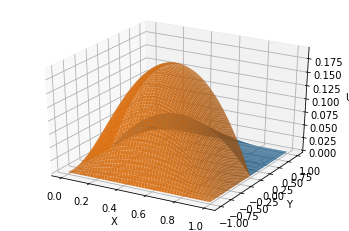

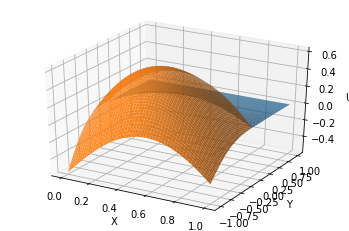

In [ ]:
x1 = tf.linspace(omga1[0][0],omga1[0][1],100)
y1 = tf.linspace(omga1[1][0],omga1[1][1],100)
x2 = tf.linspace(omga2[0][0],omga2[0][1],100)
y2 = tf.linspace(omga2[1][0],omga2[1][1],100)
 
####################################################
plt.figure(1) 
ax1 = plt.axes(projection="3d")
ax1.patch.set_facecolor("white")   #设置 axes 背景颜色

X1,Y1 = tf.meshgrid(x1,y1)
T1 = tf.ones(shape=X1.shape)
U1 = u1(X1,Y1,T1)

X2,Y2 = tf.meshgrid(x2,y2)
T2 = tf.ones(shape=X2.shape)
U2 = u2(X2,Y2,T2)

ax1.plot_surface(X1,Y1,U1,alpha=0.9) #生成曲面z，alpha调节透明度，cmap调节曲面色调
ax1.plot_surface(X2,Y2,U2,alpha=0.9)
ax1.set_xlabel("X")   
ax1.set_ylabel("Y")
ax1.set_zlabel("U")
#ax1.title("解析")
######################################################
plt.figure(2) 
ax2 = plt.axes(projection="3d")
ax2.patch.set_facecolor("white") 

x = tf.reshape(X1,shape=(10000,1))
y = tf.reshape(Y1,shape=(10000,1))
t = tf.reshape(Y1,shape=(10000,1))
X_u1 = tf.concat([x,y,t],axis=1)
U1_pred = model_1(X_u1)
U1_pred = U1_pred.numpy().reshape(U1.shape)
ax2.plot_surface(X1,Y1,U1_pred,alpha=0.9)

x = tf.reshape(X2,shape=(10000,1))
y = tf.reshape(Y2,shape=(10000,1))
t = tf.reshape(Y2,shape=(10000,1))
X_u2 = tf.concat([x,y,t],axis=1)
U2_pred = model_2(X_u2)
U2_pred = U2_pred.numpy().reshape(U2.shape)
ax2.plot_surface(X2,Y2,U2_pred,alpha=0.9)


ax2.set_xlabel("X")   
ax2.set_ylabel("Y")
ax2.set_zlabel("U")

########################################################
plt.show()

In [ ]:
xx = tf.constant([[0.0,-1.0,1.0]])
model_2(xx)